In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,scikit-learn

Sebastian Raschka 
last updated: 2016-07-18 

CPython 3.5.1
IPython 5.0.0

numpy 1.11.0
mlxtend 0.4.2.dev0
matplotlib 1.5.1
scikit-learn 0.17.1


---

This Jupyter notebook contains the code to create the data visualizations for the article "Model evaluation, model selection, and algorithm selection in machine learning - Part II" at http://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html.

---

# Confidence Intervals via Holdout and K-fold

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


iris = load_iris()
X, y = iris.data, iris.target
X, y = X[50:150, [0, 1]], y[50:150]
y = np.where(y == 2, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=123,
                                                    stratify=y)

In [4]:
lr1 = LogisticRegression(penalty='l2', 
                         dual=False, 
                         tol=0.0001, 
                         C=1.0, 
                         fit_intercept=True, 
                         intercept_scaling=1, 
                         class_weight=None, 
                         random_state=1, 
                         solver='lbfgs', 
                         max_iter=100, 
                         multi_class='multinomial', 
                         verbose=0, 
                         warm_start=False, 
                         n_jobs=1)

## Holdout method and binomial approximation

In [5]:
y_pred_1 = lr1.fit(X_train, y_train).predict(X_test)
y_pred_1_acc = np.mean(y_test == y_pred_1)

y_pred_1_std = np.sqrt(y_pred_1_acc*(1. - y_pred_1_acc) / y_pred_1.shape[0])
y_pred_1_sterr = y_pred_1_std / np.sqrt(y_pred_1.shape[0])
y_pred_1_ci95 = 1.96 * y_pred_1_std

print(y_pred_1_acc)
print(y_pred_1_std)
print(y_pred_1_sterr)
print(y_pred_1_ci95)

0.766666666667
0.0772202237951
0.0140984194894
0.151351638638


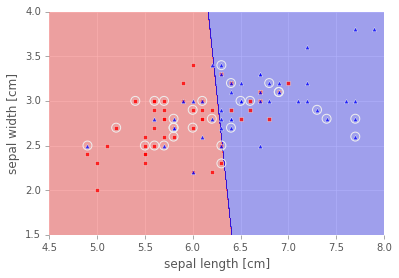

In [6]:
from mlxtend.evaluate import plot_decision_regions

with plt.style.context(('ggplot')):
    plot_decision_regions(X=X, y=y, clf=lr1, X_highlight=X_test, legend=None, res=0.002)
    plt.xlim([4.5, 8])
    plt.ylim([1.5, 4])
    plt.xlabel('sepal length [cm]')
    plt.ylabel('sepal width [cm]')
    plt.savefig('figures/iris_small_holdout_1.svg')
    plt.show()

## Holdout method and repeated sampling

In [7]:
rng = np.random.RandomState(seed=123)
seeds = np.arange(10**7)
rng.shuffle(seeds)
seeds = seeds[:50]

pred2 = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=i,
                                                        stratify=y)
    y_pred_i = lr1.fit(X_train, y_train).predict(X_test)
    y_pred_i_acc = np.mean(y_test == y_pred_i)
    pred2.append(y_pred_i_acc)

pred2 = np.asarray(pred2)
pred2_mean = pred2.mean()
pred2_std = pred2.std()
pred2_ci95 = 1.96 * pred2_std / np.sqrt(len(seeds))

print(pred2_mean)
print(pred2_std)
print(pred2_ci95)

0.726666666667
0.0754247233266
0.0209066666667


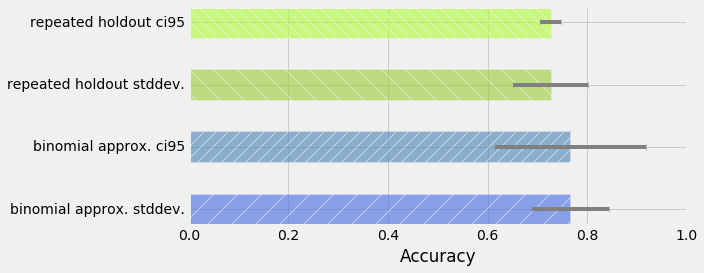

In [9]:
means = [y_pred_1_acc, y_pred_1_acc, pred2_mean, pred2_mean]
ci = [y_pred_1_std, y_pred_1_ci95, pred2_std, pred2_ci95]
colors = ['royalblue', 'steelblue', 'yellowgreen', 'greenyellow']
hatches = ['/', '//', '\\', '\\\\']
labels = ['binomial approx. stddev.', 'binomial approx. ci95',
          'repeated holdout stddev.', 'repeated holdout ci95']


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.6,
                         ecolor='gray',
                         color=c,
                         hatch=hatches[i],
                         xerr=ci[i])

    #ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    #ax.legend(loc='upper center', ncol=1)
    #plt.savefig('./iris_comp_ci_small_1_1.svg')
    #ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.8), ncol=1) 
    #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('figures/iris_comp_ci_small_1.svg')
    plt.show()

## K-fold and standard deviation

In [10]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=123)
y_pred_cv_1 = cross_val_score(estimator=lr1, 
                              X=X,
                              y=y,
                              scoring='accuracy', 
                              cv=cv, 
                              n_jobs=-1)

y_pred_cv_1_mean = y_pred_cv_1.mean()
y_pred_cv_1_std = np.sqrt(y_pred_cv_1_mean*(1. - y_pred_cv_1_mean) / y.shape[0])
y_pred_cv_1_ci95 = 1.96 * y_pred_cv_1_std

print(y_pred_cv_1_mean, y_pred_cv_1_std, y_pred_cv_1_ci95)

0.75 0.0433012701892 0.0848704895709


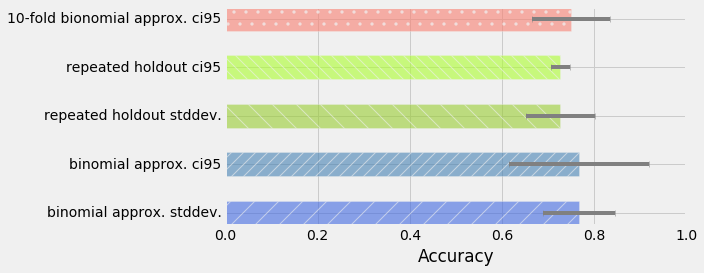

In [11]:
means = [y_pred_1_acc, y_pred_1_acc, 
         pred2_mean, pred2_mean,
         y_pred_cv_1_mean]
ci = [y_pred_1_std, y_pred_1_ci95, 
      pred2_std, pred2_ci95,
      y_pred_cv_1_ci95]
colors = ['royalblue', 'steelblue', 'yellowgreen', 'greenyellow', 'salmon']
hatches = ['/', '//', '\\', '\\\\', '.']
labels = ['binomial approx. stddev.', 'binomial approx. ci95',
          'repeated holdout stddev.', 'repeated holdout ci95',
          '10-fold bionomial approx. ci95']


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.6,
                         ecolor='gray',
                         color=c,
                         hatch=hatches[i],
                         xerr=ci[i])

    #ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    #ax.legend(loc='upper center', ncol=1)
    #plt.savefig('./iris_comp_ci_small_1_1.svg')
    #ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.8), ncol=1) 
    #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('figures/iris_comp_ci_small_2.svg')
    plt.show()

## Repeated k-fold

In [12]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score

rng = np.random.RandomState(seed=123)
seeds = np.arange(10**7)
rng.shuffle(seeds)
seeds = seeds[:50]

pred3 = []

for i in seeds:
    cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=i)
    y_pred_cv_1 = cross_val_score(estimator=lr1, 
                                  X=X,
                                  y=y,
                                  scoring='accuracy', 
                                  cv=cv, 
                                  n_jobs=-1)
    
    pred3.append(y_pred_cv_1.mean())

pred2 = np.asarray(pred2)
pred2_mean = pred2.mean()
pred2_std = pred2.std()
pred2_ci95 = 1.96 * pred2_std / np.sqrt(50)


pred3 = np.asarray(pred3)
y_pred_cv_2_mean = pred3.mean()
y_pred_cv_2_std = pred3.std()
y_pred_cv_2_ci95 = 1.96 * y_pred_cv_2_std / np.sqrt(len(seeds))

print(y_pred_cv_2_mean, y_pred_cv_2_std, y_pred_cv_2_ci95)

0.7352 0.0106282642045 0.00294600453496


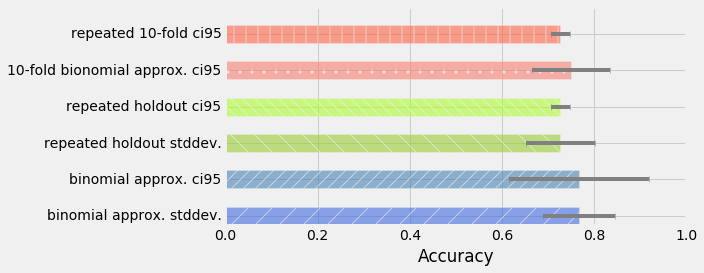

In [13]:
means = [y_pred_1_acc, y_pred_1_acc, 
         pred2_mean, pred2_mean,
         y_pred_cv_1_mean, pred2_mean]
ci = [y_pred_1_std, y_pred_1_ci95, 
      pred2_std, pred2_ci95,
      y_pred_cv_1_ci95, pred2_ci95]
colors = ['royalblue', 'steelblue', 'yellowgreen', 
          'greenyellow', 'salmon', 'tomato']
hatches = ['/', '//', '\\', '\\\\', '.', '|']
labels = ['binomial approx. stddev.', 'binomial approx. ci95',
          'repeated holdout stddev.', 'repeated holdout ci95',
          '10-fold bionomial approx. ci95', 'repeated 10-fold ci95']


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.6,
                         ecolor='gray',
                         color=c,
                         hatch=hatches[i],
                         xerr=ci[i])

    #ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    #ax.legend(loc='upper center', ncol=1)
    #plt.savefig('./iris_comp_ci_small_1_1.svg')
    #ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.8), ncol=1) 
    #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('figures/iris_comp_ci_small_3.svg')
    plt.show()

## The "one-standard error" method

In [14]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=123,
                                                    stratify=y)

rng = np.random.RandomState(seed=123)
seeds = np.arange(10**7)
rng.shuffle(seeds)
seeds = seeds[:5]

c_vals = [2**i for i in range(-2, 7)]

cv_scores, cv_stderr = [], []
for c in c_vals:
    svc = SVC(C=c, 
              kernel='rbf', 
              degree=3, 
              gamma=0.01, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape=None, 
              random_state=123)

    pred_mean = []

    for i in seeds:
        cv = StratifiedKFold(y_train, n_folds=10, shuffle=True, random_state=i)
        y_pred_cv = cross_val_score(estimator=svc, 
                                    X=X_train,
                                    y=y_train,
                                    scoring='accuracy', 
                                    cv=cv, 
                                    n_jobs=-1)

        pred_mean.append(y_pred_cv.mean())
    
    pred_mean = np.array(pred_mean)
    cv_scores.append(pred_mean.mean())
    cv_stderr.append(pred_mean.std() / np.sqrt(len(seeds)))
    
    
    cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=123)
    y_pred_cv_i = cross_val_score(estimator=svc, 
                                  X=X,
                                  y=y,
                                  scoring='accuracy', 
                                  cv=cv, 
                                  n_jobs=-1)
    
print(cv_scores)
print(cv_stderr)

[0.66083333333333338, 0.66083333333333338, 0.66083333333333338, 0.6925, 0.6941666666666666, 0.68500000000000005, 0.71333333333333326, 0.70083333333333331, 0.71083333333333321]
[0.0077817450199524898, 0.0077817450199524898, 0.0077817450199524898, 0.00217306746840088, 0.0025276251480171878, 0.0053489355119604133, 0.0084491945704243884, 0.0049159604012508785, 0.0063025568003963542]


In [15]:
max_idx = np.argmax(cv_scores)
for idx, scr in enumerate(cv_scores):
    if scr >= (cv_scores[max_idx] - cv_stderr[max_idx]):
        print(idx, scr)

6 0.713333333333
8 0.710833333333


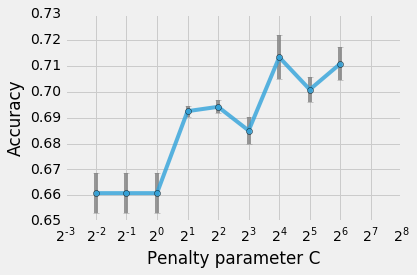

In [16]:
with plt.style.context(('fivethirtyeight')):

    fig, ax = plt.subplots()
    ax.errorbar(c_vals, 
                cv_scores, 
                yerr=cv_stderr, 
                ecolor='gray', 
                marker='o', 
                alpha=0.8)
    ax.set_xscale('log', basex=2)
    plt.xlim([2**(-3), 2**(8)])
    ax.set_xlabel('Penalty parameter C')
    ax.set_ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig('figures/iris_comp_ci_small_hyperparam_opt.svg')
    plt.show()

In [17]:
svc = SVC(C=2**4, 
          kernel='rbf', 
          degree=3, 
          gamma=0.01, 
          coef0=0.0, 
          shrinking=True, 
          probability=False, 
          tol=0.001, 
          cache_size=200, 
          class_weight=None, 
          verbose=False, 
          max_iter=-1, 
          decision_function_shape=None, 
          random_state=123)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc = np.mean(y_pred == y_test)

std = np.sqrt(acc*(1. - acc) / y_test.shape[0])
sterr = std / np.sqrt(y_test.shape[0])
ci95 = 1.96 * std



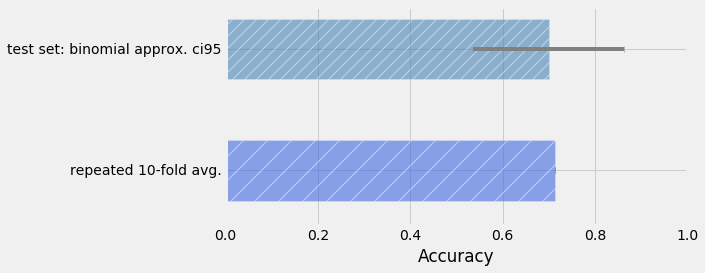

In [18]:
means = [cv_scores[6], acc]
ci = [0.0, ci95]
colors = ['royalblue', 'steelblue']
hatches = ['/', '//']
labels = ['repeated 10-fold avg.', 'test set: binomial approx. ci95']


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.6,
                         ecolor='gray',
                         color=c,
                         hatch=hatches[i],
                         xerr=ci[i])

    #ax.get_xaxis().set_ticks([])
    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    #ax.legend(loc='upper center', ncol=1)
    #plt.savefig('./iris_comp_ci_small_1_1.svg')
    #ax.legend(loc='upper center', bbox_to_anchor=(1.4, 0.8), ncol=1) 
    #plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout()
    plt.savefig('figures/iris_comp_ci_small_tuned_1.svg')
    plt.show()